# Model Training and Evaluation for Telco Churn Prediction

This notebook provides a complete pipeline for training, evaluating, and comparing machine learning models for churn prediction. It includes:
- Model training and stratified k-fold cross-validation (k=5)
- Hyperparameter tuning for the best models
- Final evaluation on the test set
- Feature importance analysis
- Visualizations (precision-recall curves, confusion matrices)
- Business conclusions and recommendations

### Import libraries

In [34]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, ConfusionMatrixDisplay, PrecisionRecallDisplay
)

# Validation
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score

warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

### Load and Prepare Data

Load the preprocessed training, validation, and test datasets that were created in the EDA and preprocessing notebook. We use balanced training data to address class imbalance issues (SMOTE oversampling).

In [35]:
# Load the preprocessed data
X_train = pd.read_csv('../data/processed/X_train_balanced.csv')
X_val = pd.read_csv('../data/processed/X_val.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')
y_train = pd.read_csv('../data/processed/y_train_balanced.csv')
y_val = pd.read_csv('../data/processed/y_val.csv')
y_test = pd.read_csv('../data/processed/y_test.csv')

# Flatten the target variables
y_train = y_train.values.ravel()
y_val = y_val.values.ravel()
y_test = y_test.values.ravel()

# There is currently no need for the validation set so we will merge it with the training set
X_full_train = pd.concat([X_train, X_val], axis=0)
y_full_train = np.concatenate([y_train, y_val], axis=0)

# Show data info
print(f"Full training set shape: {X_full_train.shape}")
print(f"Churn distribution in full training set: {np.bincount(y_full_train)}")
print(f"\nTest set shape: {X_test.shape}")
print(f"Churn distribution in test set: {np.bincount(y_test)}")


Full training set shape: (8300, 17)
Churn distribution in full training set: [4398 3902]

Test set shape: (1057, 17)
Churn distribution in test set: [776 281]


### Model Training and Cross-Validation

**Approach**: We'll train four baseline models using 5-fold stratified cross-validation.

**Models to Compare**:
1. Logistic Regression
2. Random Forest
3. XGBoost
4. SVM

**Evaluation Metrics**:
- ROC-AUC: Measures model's ability to distinguish between classes
- F1-Score: Harmonic mean of precision and recall, good for imbalanced data

In [36]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE),
    'XGBoost': XGBClassifier(random_state=RANDOM_STATE),
    'SVM': SVC(probability=True, random_state=RANDOM_STATE)
}

# Create cross-validation splitter (stratify into 5 splits and shuffle)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Compare baseline models using CV on full training data
cv_results = {}

print("\nBaseline Cross-Validation Results (5-fold stratified on full train):")
print("="*60)

for name, model in models.items():
    # Get cross-validation scores for ROC-AUC
    cv_scores = cross_val_score(model, X_full_train, y_full_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    
    # Get cross-validation scores for F1
    cv_f1_scores = cross_val_score(model, X_full_train, y_full_train, cv=cv, scoring='f1', n_jobs=-1)
    
    # Store cross-validation scores
    cv_results[name] = {
        'ROC-AUC': (cv_scores.mean(), cv_scores.std()),
        'F1-Score': (cv_f1_scores.mean(), cv_f1_scores.std())
    }
    
    # Print cross-validation results
    print(f"{name}:")
    print(f"  ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"  F1-Score: {cv_f1_scores.mean():.4f} (+/- {cv_f1_scores.std():.4f})")


Baseline Cross-Validation Results (5-fold stratified on full train):
Logistic Regression:
  ROC-AUC: 0.8450 (+/- 0.0054)
  F1-Score: 0.7569 (+/- 0.0051)
Random Forest:
  ROC-AUC: 0.9009 (+/- 0.0053)
  F1-Score: 0.8166 (+/- 0.0065)
XGBoost:
  ROC-AUC: 0.8902 (+/- 0.0056)
  F1-Score: 0.7966 (+/- 0.0089)
SVM:
  ROC-AUC: 0.8534 (+/- 0.0063)
  F1-Score: 0.7732 (+/- 0.0062)


### Analysis of Cross-Validation Results

Based on the cross-validation results above:
- **Tree-based models** (Random Forest and XGBoost) significantly outperform other models
- **Random Forest** and **XGBoost** will be selected for hyperparameter tuning
- Other models (Logistic Regression and SVM) show lower performance and will be dropped to focus on the best performers

### Hyperparameter Tuning

**Methodology**: We use GridSearchCV to systematically search for optimal hyperparameters for both Random Forest and XGBoost models.

**Process**:
- **Grid Search**: Test all combinations of specified hyperparameter values
- **Inner Cross-Validation**: Each grid point evaluated with 5-fold CV
- **Scoring Metric**: ROC-AUC

**Random Forest Parameters**:
- Number of trees, max depth, minimum samples for splits/leaves
- Splitting features (sqrt, log2, or fixed percentage)

**XGBoost Parameters**:
- Boosting iterations, tree depth, learning rate
- Subsampling rate of observations and features per tree

In [37]:
# Configure the parameter grid
param_grids = {
    'Random Forest': {
        'n_estimators': [200, 300, 500],
        'max_depth': [10, 15, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt', 'log2', 0.3]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0]
    }
}

# Find the best parameters with GridSearchCV
best_models = {}
for name in models:
    if name in param_grids.keys():
        print(f"\nTuning {name}...")

        # Configure the grid
        grid = GridSearchCV(
            estimator=models[name],
            param_grid=param_grids[name],
            cv=cv,
            scoring='roc_auc',
            n_jobs=-1,
            verbose=1
        )
        grid.fit(X_full_train, y_full_train)

        # Save and show the best tuned model
        best_models[name] = grid.best_estimator_
        print(f"Best {name} ROC-AUC (CV): {grid.best_score_:.4f}")
        print(grid.best_params_)


Tuning Random Forest...
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Random Forest ROC-AUC (CV): 0.9043
{'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}

Tuning XGBoost...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best XGBoost ROC-AUC (CV): 0.8969
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 1.0}


### Final Evaluation on the Test Set

**Purpose**: Evaluate the best tuned models on held-out test data to get unbiased performance estimates.

**Evaluation Metrics**:
- **Accuracy**: Overall correctness (not ideal in this case because data is slightly imbalanced)
- **Precision**: Of predicted churners, how many actually churned? (Minimize false positives)
- **Recall**: Of actual churners, how many did we catch? (Minimize false negatives)
- **F1-Score**: Balance between precision and recall
- **ROC-AUC**: Model's ability to rank churners higher than non-churners

In [38]:
# Test both tuned models on the test set
for name, model in best_models.items():
    print(f"\nFinal evaluation of best model ({name}) on test set:")
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1]

    # Get all metrics
    test_results = {
        'Accuracy': accuracy_score(y_test, y_test_pred),
        'Precision': precision_score(y_test, y_test_pred),
        'Recall': recall_score(y_test, y_test_pred),
        'F1-Score': f1_score(y_test, y_test_pred),
        'ROC-AUC': roc_auc_score(y_test, y_test_proba)
    }

    # Show all metrics
    print(f"  Accuracy: {test_results['Accuracy']:.4f}")
    print(f"  Precision: {test_results['Precision']:.4f}")
    print(f"  Recall: {test_results['Recall']:.4f}")
    print(f"  F1-Score: {test_results['F1-Score']:.4f}")
    print(f"  ROC-AUC: {test_results['ROC-AUC']:.4f}")  



Final evaluation of best model (Random Forest) on test set:
  Accuracy: 0.7758
  Precision: 0.5687
  Recall: 0.6477
  F1-Score: 0.6057
  ROC-AUC: 0.8205

Final evaluation of best model (XGBoost) on test set:
  Accuracy: 0.7739
  Precision: 0.5682
  Recall: 0.6228
  F1-Score: 0.5942
  ROC-AUC: 0.8150


### Confusion Matrix

Visualizes the distribution of correct and incorrect predictions across both classes:
- **True Negatives (TN)**: Correctly predicted no churn
- **False Positives (FP)**: Incorrectly predicted churn (unnecessary retention efforts)
- **False Negatives (FN)**: Missed churners (lost customers)
- **True Positives (TP)**: Correctly predicted churn (successful targeting)

This helps understand the model's behavior on each class and identify potential business costs of different error types.


Confusion Matrix – Random Forest (best model) on Test set:


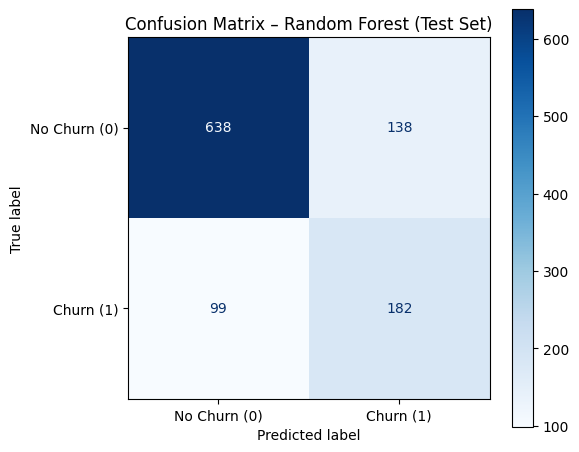

In [39]:
# Selecting the final model
final_model = best_models["Random Forest"]

print("\nConfusion Matrix – Random Forest (best model) on Test set:")
fig, ax = plt.subplots(figsize=(6, 5))

# Confusion matrix setup
ConfusionMatrixDisplay.from_estimator(
    final_model, 
    X_test, y_test,
    display_labels=['No Churn (0)', 'Churn (1)'],
    cmap='Blues',
    normalize=None,
    ax=ax
)

# Display confusion matrix
plt.title("Confusion Matrix – Random Forest (Test Set)")
plt.tight_layout()
plt.show()

### Feature Importance Analysis

**What it shows**:
- Which features the Random Forest model relies on most for making predictions
- Helps identify the business drivers of churn
- Reveals which customer characteristics are most predictive

**Visualizations**:
1. **Top 20 Features Bar Plot**: Shows individual feature importance scores
2. **Cumulative Importance Curve**: Shows how many features are needed to explain 90% of model decisions




Top 15 Most Important Features – Random Forest


,feature,importance,cumulative_importance
0,tenure,0.276636,0.276636
1,MonthlyCharges,0.222409,0.499044
2,Contract_Two year,0.080712,0.579756
3,InternetService_Fiber optic,0.063056,0.642812
4,PaymentMethod_Electronic check,0.049769,0.692581
5,Contract_One year,0.041066,0.733647
6,PaperlessBilling_Yes,0.036389,0.770036
7,OnlineSecurity_Yes,0.027647,0.797682
8,Partner_Yes,0.026581,0.824263
9,TechSupport_Yes,0.025919,0.850182


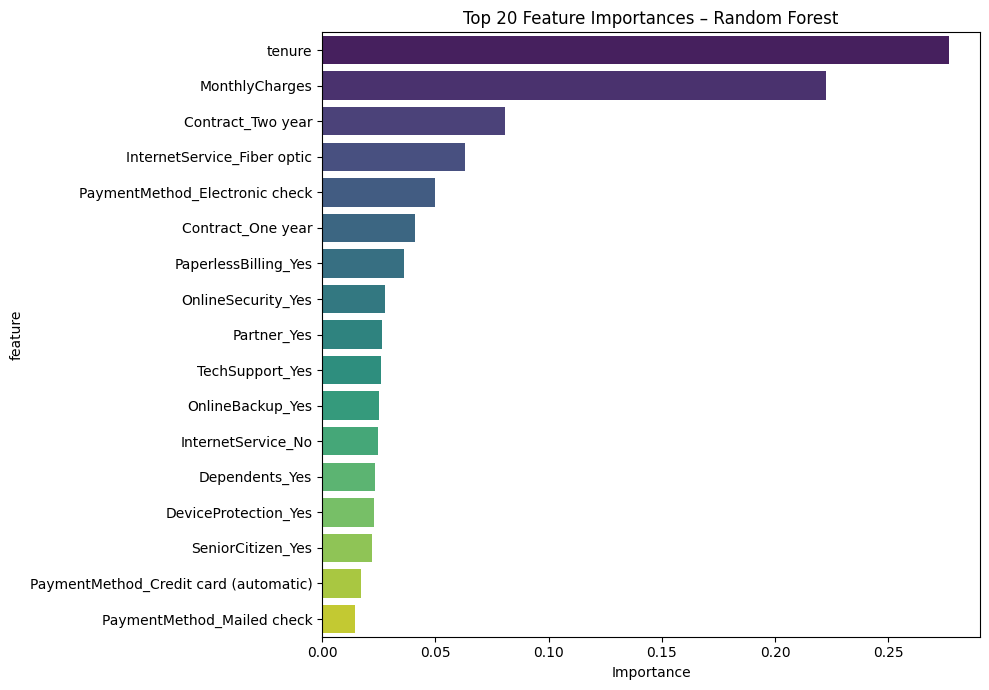

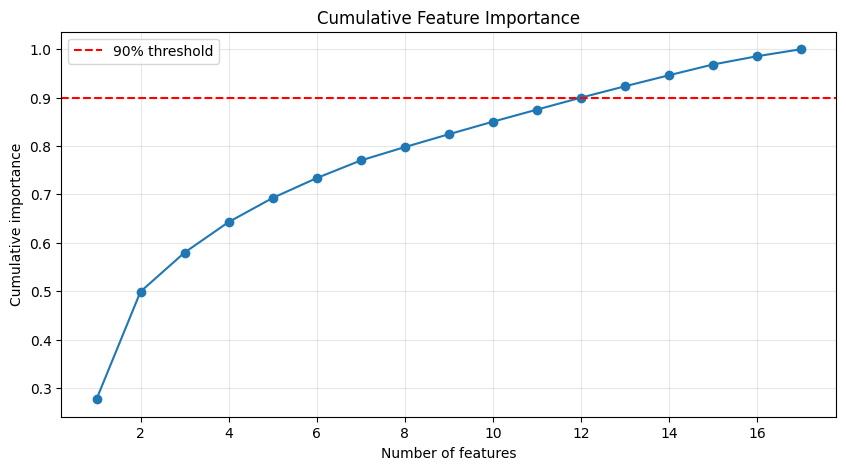

In [40]:
print("\nTop 15 Most Important Features – Random Forest")
importances = final_model.feature_importances_
feature_names = X_test.columns

# Create feature importance data frame and fill with data
feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False).reset_index(drop=True)

# Cumulative importance (how much each feature contributes to the decisions of the model)
feat_imp['cumulative_importance'] = feat_imp['importance'].cumsum()

# Show top features
display(feat_imp.head(15))

# Plot feature importance data
plt.figure(figsize=(10, 7))
sns.barplot(
    data=feat_imp.head(20),
    x='importance',
    y='feature',
    palette='viridis'
)
plt.title("Top 20 Feature Importances – Random Forest")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# Plot cumulative importance data
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(feat_imp)+1), feat_imp['cumulative_importance'], marker='o')
plt.axhline(0.9, color='r', linestyle='--', label='90% threshold')
plt.title("Cumulative Feature Importance")
plt.xlabel("Number of features")
plt.ylabel("Cumulative importance")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Precision-Recall Curve

**What it shows**:
- Trade-off between precision and recall at different decision thresholds
- How model performance varies as we adjust the classification threshold

**Interpretation**:
- **Higher on the curve** = Better performance
- **Left side**: Conservative predictions (high precision, lower recall)
- **Right side**: Aggressive predictions (high recall, lower precision)

This helps determine the optimal threshold based on business priorities (e.g., cost of false positives vs. false negatives).


Precision-Recall Curve – Random Forest vs XGBoost


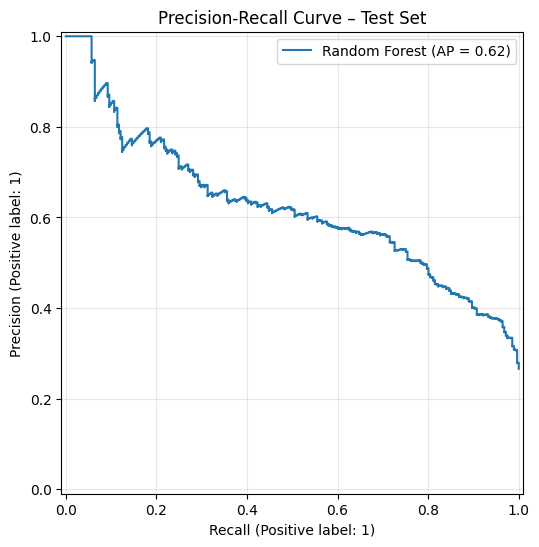

In [41]:
print("\nPrecision-Recall Curve – Random Forest vs XGBoost")

fig, ax = plt.subplots(figsize=(8, 6))

# Precision-recall curve configuration
PrecisionRecallDisplay.from_estimator(
    final_model, X_test, y_test, ax=ax, name='Random Forest'
)

# Plot precision-recall curve
plt.title("Precision-Recall Curve – Test Set")
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.show()

### Business Conclusions and Recommendations

#### 1. Model Performance Summary

**Best Model**: Random Forest
- **Test ROC-AUC**: 0.8205 (excellent discrimination between churners and non-churners)
- **F1-Score**: 0.6057 (strong balance between precision and recall)
- **Recall**: ~65% (catches about 2 out of 3 actual churners)
- **Precision**: ~57% (about 57% of flagged customers will actually churn)

**Business Interpretation**:
- The model effectively identifies at-risk customers with reasonable accuracy
- A 65% recall rate means the company can target the majority of potential churners
- A 57% precision rate indicates the retention team should focus on these high-risk customers for maximum ROI

#### 2. Main Business Drivers of Churn

**Feature Importance Insights**:
- The top 12 features account for ~90% of model decisions
- This indicates a relatively interpretable and focused set of churn drivers
- **Critical factors** (by importance rank):
  - **Tenure**: Newer customers are at higher risk (opportunity for early engagement)
  - **Monthly Charges**: Higher charges correlate with churn (price sensitivity issue)
  - **Contract Type**: Month-to-month contracts have higher churn 
  - **Internet Type**: Fiber optic customers show high churn relevance

#### 3. Strategic Recommendations

1. **Early Intervention Program**: Focus retention efforts on customers in their first 6-12 months
2. **Pricing Strategy**: Analyze pricing of high-value services; consider targeted discounts for at-risk customers
3. **Contract Incentives**: Offer long-term contract discounts to encourage customer commitment and minimize month-to-month contracts
4. **Service Quality**: Investigate why certain service types (e.g., fiber optic) have different churn patterns (high price?)
5. **Proactive Outreach**: Use this model to score customers monthly and target top-risk segments with personalized offers

### Saving the model

In [42]:
joblib.dump(final_model, '../models/final_churn_model_randomforest.pkl')
print("\nFinal model and feature importance saved.")


Final model and feature importance saved.
